0-Par1.DRR.0.19.08.2023.1719.csv
1-Par1.DRR.0.19.08.2023.2308.csv
2-Par1.DRR.270.19.08.2023.1801.csv
3-Par1.DRR.270.19.08.2023.2318.csv
4-Par2.DRR.0.19.08.2023.1838.csv
5-Par2.DRR.0.19.08.2023.2335.csv
6-Par2.DRR.270.19.08.2023.1935.csv
7-Par2.DRR.270.19.08.2023.2349.csv
8-Par3.DRR.0.19.08.2023.2126.csv
9-Par3.DRR.0.20.08.2023.0004.csv
10-Par3.DRR.270.19.08.2023.2254.csv
11-Par3.DRR.270.19.08.2023.2254_estatistica.csv
12-Par3.DRR.270.20.08.2023.0017.csv

 Nome do Arquivo Selecionado:  Par1.DRR.0.19.08.2023.1719.csv 

------------- Histograma dos deslocamentos dos registros por método -------------


/tmp/ipykernel_9268/3303104556.py:120: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dados_de_resultados['lista_deslocamento'] = dados_de_resultados['vetor_de_deslocamento'].str.replace('[', '').replace(']', '').str.split()


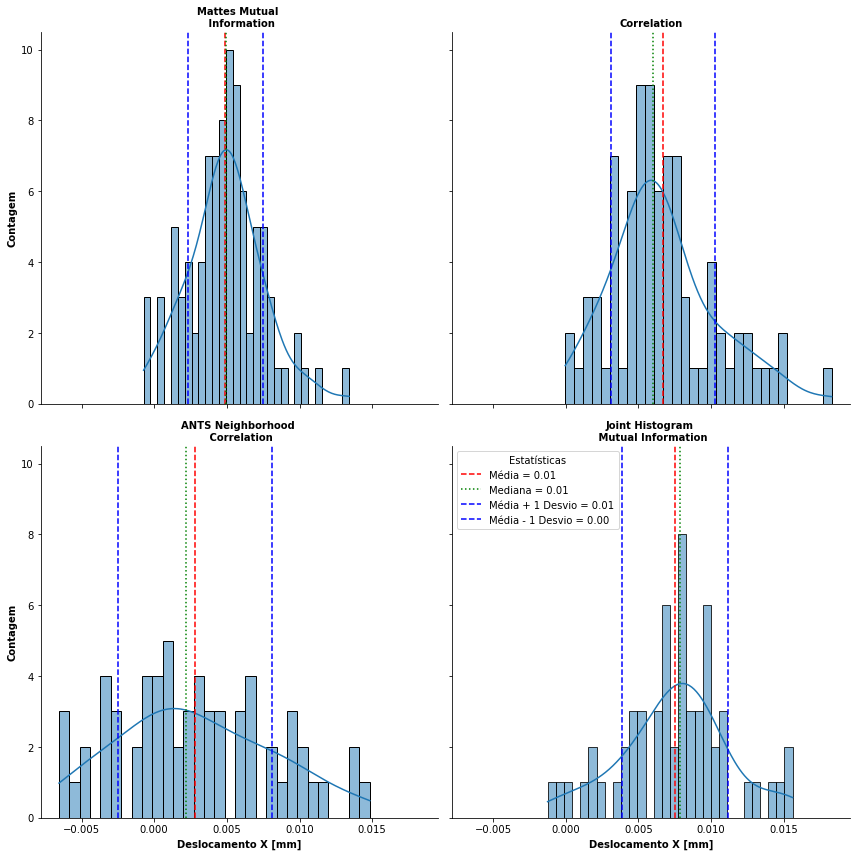

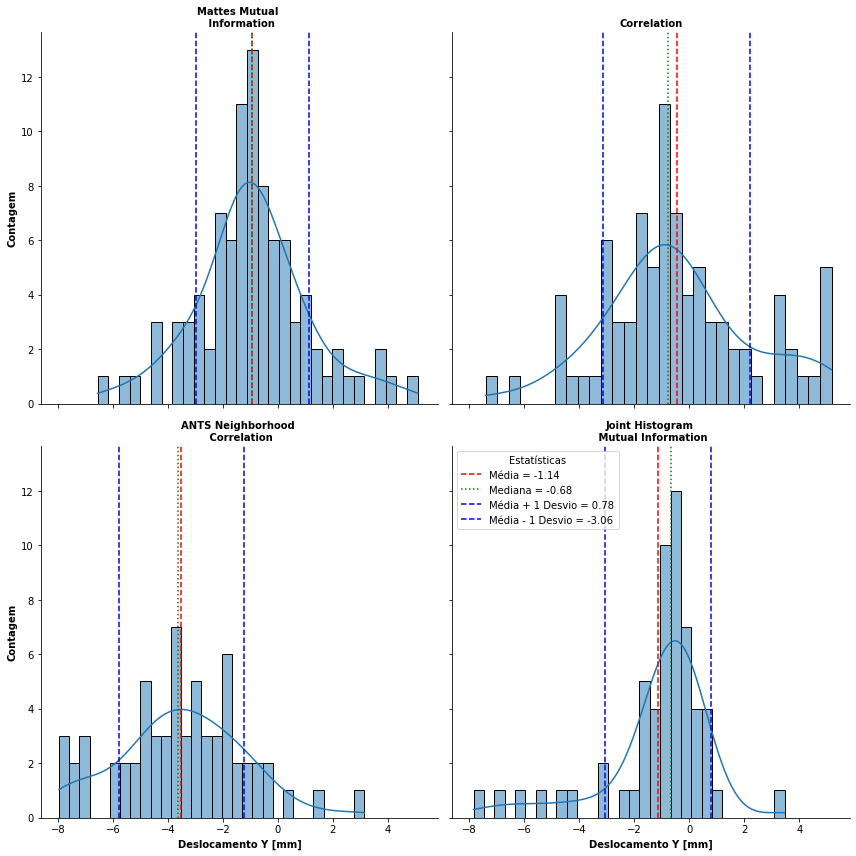

------------- Boxplot dos deslocamentos dos registros por método -------------


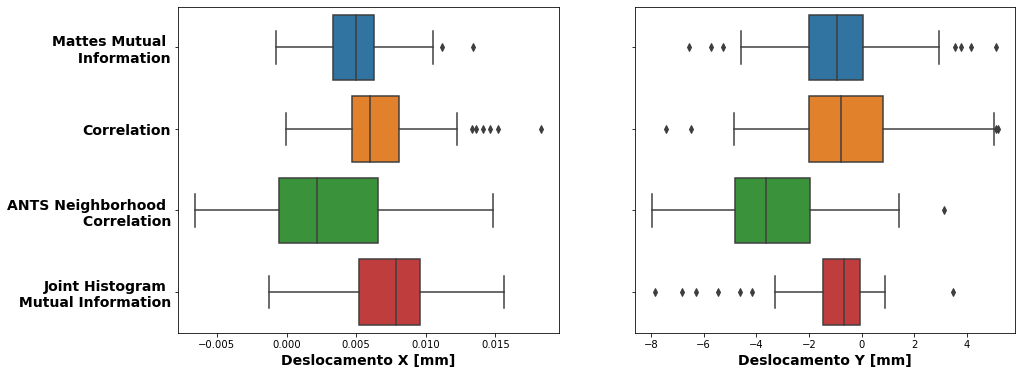

------------- Estatísticas para métrica: -------------
                                 Métrica  Média DH  Mediana DH  Desvio DH  \
0       ANTS Neighborhood \n Correlation     0.002       0.001      0.006   
1                            Correlation     0.006       0.006      0.003   
2  Joint Histogram \n Mutual Information     0.007       0.007      0.003   
3           Mattes Mutual \n Information     0.005       0.005      0.002   

   Média DV  Mediana DV  Desvio DV  media valor_final_da_metrica  \
0    -3.599      -3.618      2.249                        -0.715   
1    -0.634      -0.909      2.155                        -0.750   
2    -0.607      -0.498      0.862                        -1.133   
3    -0.962      -1.016      1.652                        -0.590   

   media tempo_total_registro  media numero_de_interacoes  
0                      13.944                      19.469  
1                       0.553                      19.231  
2                       1.125         

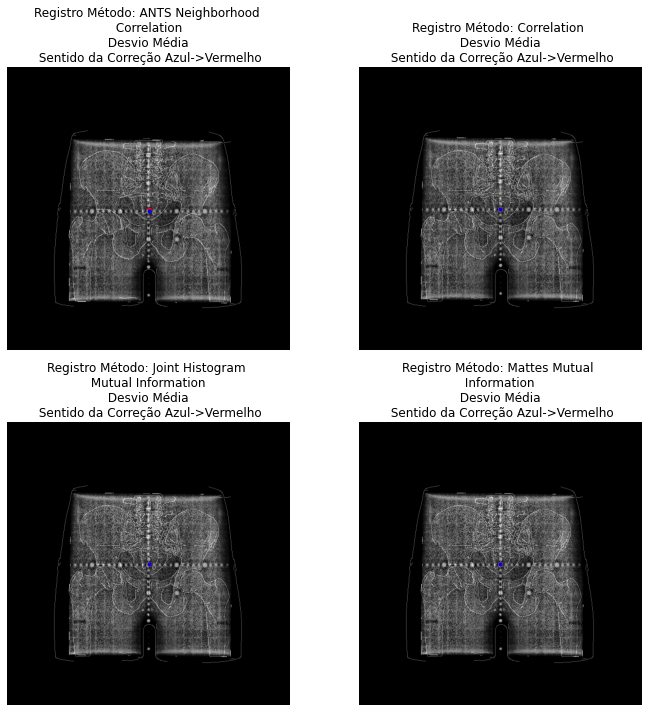

------------- Registros com valores mediano de deslocamento -------------


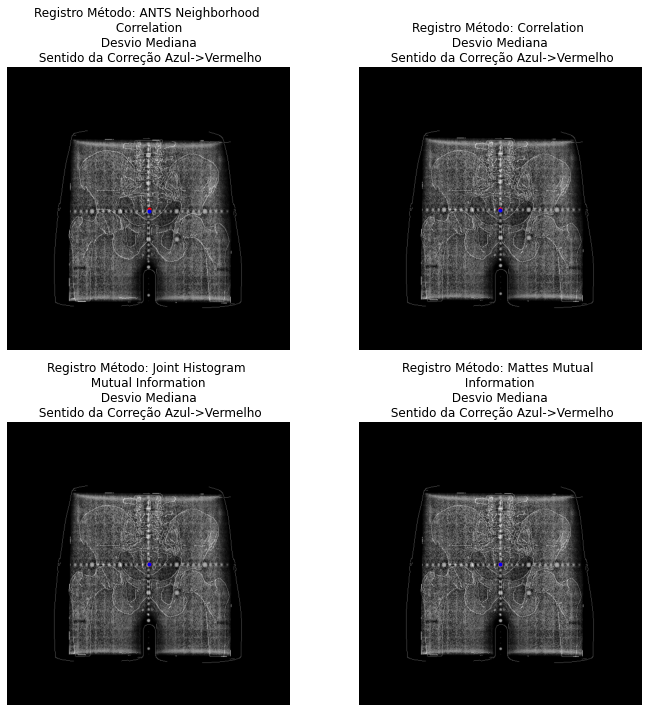

In [38]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import exposure
import seaborn as sns
import cv2

def selecionar_arquivo_resultados_csv():
    # Lista todos os arquivos CSV no diretório atual
    arquivos_csv = sorted([f for f in os.listdir('.') if f.endswith('.csv')])
    # Solicitar ao usuário para escolher um arquivo
    if not arquivos_csv:
        print("Nenhum arquivo CSV encontrado no diretório atual.")
        return None
    else:
        return arquivos_csv

def formatar_numero(num):
    #Formata o número com três casas decimais e vírgula como separador decimal
    return "{:.3f}".format(num).replace('.', ',')

def remover_outliers(dados, coluna):
    Q1 = dados[coluna].quantile(0.25)
    Q3 = dados[coluna].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 * IQR)
    return dados.loc[filtro]

def imprimir_estatistica(data, column):
    print(f'Média de {column}:', formatar_numero(np.mean(data[column])))
    print(f'Mediana de {column}:', formatar_numero(np.median(data[column])))
    print(f'Desvio padrão de {column}:', formatar_numero(np.std(data[column])))

def visualizar_resultados_registro(imagem_fixa_caminho, imagem_movimento_caminho, deslocamento, metodo, nome_calculo):
    
    if len(deslocamento) != len(metodo):
        print("Number of deslocamento and metodo must be the same!")
        return

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)  # 2x2 grid for 4 metodo
    axes = axes.ravel()
    try:
        imagem_fixa = sitk.ReadImage(imagem_fixa_caminho)
        imagem_em_movimento = sitk.ReadImage(imagem_movimento_caminho)
        imagem_fixa_itk = sitk.ReadImage(imagem_fixa_caminho)
        imagem_em_movimento_itk = sitk.ReadImage(imagem_movimento_caminho)
        # Compute the displacement in the image in pixel units
        pixel_mm_ratio = imagem_em_movimento.GetSpacing()
        imagem_fixa = sitk.GetArrayFromImage(imagem_fixa)  # convert to numpy array
        imagem_em_movimento = sitk.GetArrayFromImage(imagem_em_movimento)  # convert to numpy array
        centro_vertical, centro_horizontal = np.array(imagem_em_movimento.shape[:2]) // 2
        
    except Exception as e:
        print("Exceção ao processar imagens:", e)
        return
    
    for i, (deslocamento, method) in enumerate(zip(deslocamento, metodo)):
        ax = axes[i]
        # Calcula o deslocamento para o sistema de coordenada "matplotlib"
        deslocamento_horizontal = -deslocamento[0]
        deslocamento_vertical = -deslocamento[1]

        transforma = sitk.TranslationTransform(2)
        transforma.SetOffset((deslocamento[0], deslocamento[1]))
        reamostrado = sitk.ResampleImageFilter()
        reamostrado.SetReferenceImage(imagem_fixa_itk)
        reamostrado.SetOutputSpacing(imagem_fixa_itk.GetSpacing())
        reamostrado.SetSize(imagem_fixa_itk.GetSize())
        reamostrado.SetOutputDirection(imagem_fixa_itk.GetDirection())
        reamostrado.SetOutputOrigin(imagem_fixa_itk.GetOrigin())
        reamostrado.SetTransform(transforma)
        reamostrado_imagem_em_movimento = reamostrado.Execute(imagem_em_movimento_itk)
        reamostrado_imagem_em_movimento_np = sitk.GetArrayFromImage(reamostrado_imagem_em_movimento)

        # Aplicar a equalização adaptativa de histograma
        
        imagem_movimento_equalizada = exposure.equalize_adapthist(reamostrado_imagem_em_movimento_np, kernel_size=50)
        imagem_movimento_reamostrada_normalizada = ((imagem_movimento_equalizada - imagem_movimento_equalizada.min()) * (255 / (imagem_movimento_equalizada.max() - imagem_movimento_equalizada.min()))).astype(np.uint8)
        
        imagem_fixa_normalizada = ((imagem_fixa - imagem_fixa.min()) * (255 / (imagem_fixa.max() - imagem_fixa.min()))).astype(np.uint8)
        imagem_fixa_bordas = cv2.Canny(imagem_fixa_normalizada, 70, 100)
        
        ax.imshow(imagem_fixa_bordas, cmap='gray', origin='lower')
        ax.imshow(imagem_movimento_reamostrada_normalizada, cmap='gray', origin='lower', alpha=0.7)
        ax.invert_yaxis()
        ax.plot(centro_horizontal, centro_vertical, 'ro', markersize=3)
        ax.plot(deslocamento_horizontal + centro_horizontal, deslocamento_vertical + centro_vertical, 'bo', markersize=3)
        ax.set_title(f"Registro Método: {method} \n Desvio {nome_calculo} \n Sentido da Correção Azul->Vermelho")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Função para plotar média, mediana e desvio padrão
def plot_statistics(data, **kwargs):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    plt.axvline(mean, color='red', linestyle='--', label=f"Média = {mean:.2f}")
    plt.axvline(median, color='green', linestyle=':', label=f"Mediana = {median:.2f}")
    plt.axvline(mean + std, color='blue', linestyle='--', label=f"Média + 1 Desvio = {mean + std:.2f}")
    plt.axvline(mean - std, color='blue', linestyle='--', label=f"Média - 1 Desvio = {mean - std:.2f}")
    plt.legend()

nome_do_arquivo = selecionar_arquivo_resultados_csv()
for indice, nome in enumerate(nome_do_arquivo):
    print(f"{indice}-{nome}")

# indice do arquivo selecionado para gerar os resultados da simulacao por par de imagem
indice_arquivo_selecionado = 0

dados_de_resultados = pd.read_csv(nome_do_arquivo[indice_arquivo_selecionado], sep='\t', index_col=0)

print("\n Nome do Arquivo Selecionado: ",nome_do_arquivo[indice_arquivo_selecionado],"\n")

# Extrair os valores de gantry da coluna imagem_fixa
dados_de_resultados['gantry'] = dados_de_resultados['imagem_fixa'].str.extract('(0|270)')[0]
dados_de_resultados['lista_deslocamento'] = dados_de_resultados['vetor_de_deslocamento'].str.replace('[', '').replace(']', '').str.split()

if dados_de_resultados['gantry'][0] == "0":
    nome_eixo = "Deslocamento X [mm]"
elif dados_de_resultados['gantry'][0] == "270":
    nome_eixo = "Deslocamento Z [mm]"

# Extrair os valores de deslocamento da imagem vertical e horizontal
dados_de_resultados['deslocamento_horizontal'] = dados_de_resultados['lista_deslocamento'].apply(lambda x: float(x[0]))
dados_de_resultados['deslocamento_vertical'] = dados_de_resultados['lista_deslocamento'].apply(lambda x: float(x[1]))

# Remove os valores de deslocamento da imagem vertical e horizontal que são outliers
dados_de_resultados_no_outliers = remover_outliers(dados_de_resultados, 'deslocamento_horizontal')
dados_de_resultados_no_outliers = dados_de_resultados = remover_outliers(dados_de_resultados_no_outliers, 'deslocamento_vertical')

# Melhora a forma de mostrar o nome da metrica
renomear_metricas = {
    "MattesMutualInformation": "Mattes Mutual \n Information",
    "Correlation": "Correlation",
    "ANTSNeighborhoodCorrelation": "ANTS Neighborhood \n Correlation",
    "JointHistogramMutualInformation": "Joint Histogram \n Mutual Information"
}
dados_de_resultados_no_outliers['nome_da_metrica'].replace(renomear_metricas, inplace=True)

metricas_unicas = sorted(dados_de_resultados['nome_da_metrica'].unique())

print(f"------------- Histograma dos deslocamentos dos registros por método -------------")
# Criando gráficos
g = sns.FacetGrid(dados_de_resultados_no_outliers, col="nome_da_metrica", col_wrap=2, height=6)
g.map(sns.histplot, 'deslocamento_horizontal', bins=30, kde=True)
g.map(plot_statistics, 'deslocamento_horizontal')
g.set_titles("{col_name}", weight='bold', fontsize=20)
for ax in g.axes.flat:
    ax.set_ylabel("Contagem", weight='bold')
    ax.set_xlabel(nome_eixo, weight='bold')
plt.legend(loc='upper left', title='Estatísticas')
plt.tight_layout()
plt.show()

g = sns.FacetGrid(dados_de_resultados_no_outliers, col="nome_da_metrica", col_wrap=2, height=6)
g.map(sns.histplot, 'deslocamento_vertical', bins=30, kde=True)
g.map(plot_statistics, 'deslocamento_vertical')
g.set_titles("{col_name}", weight='bold', fontsize=20)
for ax in g.axes.flat:
    ax.set_ylabel("Contagem", weight='bold')
    ax.set_xlabel("Deslocamento Y [mm]", weight='bold')
plt.legend(loc='upper left', title='Estatísticas')
plt.tight_layout()
plt.show()

print(f"------------- Boxplot dos deslocamentos dos registros por método -------------")
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
# Primeiro gráfico BoxPlot
sns.boxplot(y='nome_da_metrica', x='deslocamento_horizontal', data=dados_de_resultados_no_outliers, ax=ax[0])
labels1 = ax[0].get_yticklabels()
ax[0].set_yticklabels(labels1, weight='bold', fontsize=14)
ax[0].set_xlabel(nome_eixo, weight='bold', fontsize=14)
ax[0].set_ylabel("")

# Segundo gráfico BoxPlot
sns.boxplot(y='nome_da_metrica', x='deslocamento_vertical', data=dados_de_resultados_no_outliers, ax=ax[1])
ax[1].set_xlabel("Deslocamento Y [mm]", weight='bold', fontsize=14)
ax[1].set_ylabel("")
#plt.tight_layout()
plt.show()

metricas_unicas = sorted(dados_de_resultados['nome_da_metrica'].unique())

print(f"------------- Estatísticas para métrica: -------------")
# Criando um DataFrame vazio para armazenar os resultados
resultados_tabulares = pd.DataFrame(columns=[
    'Métrica', 
    'Média DH', 'Mediana DH', 'Desvio DH',
    'Média DV', 'Mediana DV', 'Desvio DV',
    'media valor_final_da_metrica',
    'media tempo_total_registro',
    'media numero_de_interacoes'
])

for nome_da_metrica in metricas_unicas:
    dados_de_resultados_metrica = dados_de_resultados[dados_de_resultados['nome_da_metrica'] == nome_da_metrica]
    dados_de_resultados_no_outliers_metrica = remover_outliers(dados_de_resultados_metrica, 'deslocamento_horizontal')
    dados_de_resultados_no_outliers_metrica = remover_outliers(dados_de_resultados_no_outliers_metrica, 'deslocamento_vertical')
    dados_de_resultados_no_outliers_metrica = remover_outliers(dados_de_resultados_no_outliers_metrica, 'valor_final_da_metrica')
    dados_de_resultados_no_outliers_metrica = remover_outliers(dados_de_resultados_no_outliers_metrica, 'tempo_total_registro')
    dados_de_resultados_no_outliers_metrica = remover_outliers(dados_de_resultados_no_outliers_metrica, 'numero_de_interacoes')

    # Calculando estatísticas
    res = {
        'Métrica': nome_da_metrica,
        'Média DH': round(np.mean(dados_de_resultados_no_outliers_metrica['deslocamento_horizontal']), 3),
        'Mediana DH': round(np.median(dados_de_resultados_no_outliers_metrica['deslocamento_horizontal']), 3),
        'Desvio DH': round(np.std(dados_de_resultados_no_outliers_metrica['deslocamento_horizontal']), 3),
        'Média DV': round(np.mean(dados_de_resultados_no_outliers_metrica['deslocamento_vertical']), 3),
        'Mediana DV': round(np.median(dados_de_resultados_no_outliers_metrica['deslocamento_vertical']), 3),
        'Desvio DV': round(np.std(dados_de_resultados_no_outliers_metrica['deslocamento_vertical']), 3),
        'media valor_final_da_metrica': round(np.mean(dados_de_resultados_no_outliers_metrica['valor_final_da_metrica']), 3),
        'media tempo_total_registro': round(np.mean(dados_de_resultados_no_outliers_metrica['tempo_total_registro']), 3),
        'media numero_de_interacoes': round(np.mean(dados_de_resultados_no_outliers_metrica['numero_de_interacoes']), 3)
    }

    # Adicionando linha de resultados ao DataFrame
    resultados_tabulares = resultados_tabulares.append(res, ignore_index=True)

# Exibindo o DataFrame
print(resultados_tabulares)

novo_nome_do_arquivo = nome_do_arquivo[indice_arquivo_selecionado].replace(".tsv", "_estatistica.csv")
resultados_tabulares.to_csv(novo_nome_do_arquivo, sep='\t', encoding='utf-8-sig', index=False)

# Agrupar por método e para calcular a média de deslocamento_horizontal e deslocamento_vertical
agrupado = dados_de_resultados_no_outliers.groupby('nome_da_metrica').agg({
    'deslocamento_horizontal': 'mean',
    'deslocamento_vertical': 'mean'
}).reset_index()

# Criar lista de métodos e translações
metodo = agrupado['nome_da_metrica'].tolist()
deslocamento = list(zip(agrupado['deslocamento_horizontal'], agrupado['deslocamento_vertical']))

imagem_fixa_caminho = dados_de_resultados_no_outliers['imagem_fixa'].iloc[0]
imagem_movimento_caminho = dados_de_resultados_no_outliers['imagem_em_movimento'].iloc[0]

print(f"------------- Registros com valores médio de deslocamento -------------")
visualizar_resultados_registro(imagem_fixa_caminho, imagem_movimento_caminho, deslocamento, metodo, "Média")

# Agrupar por método e para calcular a mediana de deslocamento_horizontal e deslocamento_vertical
agrupado = dados_de_resultados_no_outliers.groupby('nome_da_metrica').agg({
    'deslocamento_horizontal': 'median',
    'deslocamento_vertical': 'median'
}).reset_index()

# Criar lista de métodos e translações
metodo = agrupado['nome_da_metrica'].tolist()
deslocamento = list(zip(agrupado['deslocamento_horizontal'], agrupado['deslocamento_vertical']))

print(f"------------- Registros com valores mediano de deslocamento -------------")
visualizar_resultados_registro(imagem_fixa_caminho, imagem_movimento_caminho, deslocamento, metodo, "Mediana")